<a href="https://colab.research.google.com/github/Frodo-Swaggins/COMP702PROJECT/blob/main/comp703project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

START OF PREPROCESSING

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#imports and creating the path to the images
import os
import cv2
cv2.__version__
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join

mypath = '/content/drive/MyDrive/RandNotes'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

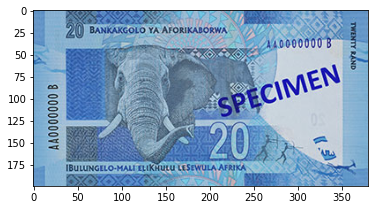

In [4]:
#Opening the images and loading them as image objects into an array using open cv
images = []
count = 0

for fil in onlyfiles:
  imagepath = '/content/drive/MyDrive/RandNotes/' + fil
  image = cv2.imread(imagepath)
  images.append(image)

plt.imshow(images[0])

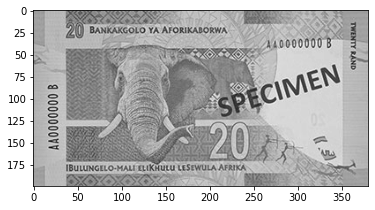

In [5]:
#grayscale conversion on the array of images
grays = []
for image in images:
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  grays.append(gray)
plt.imshow(grays[0], cmap = 'gray')

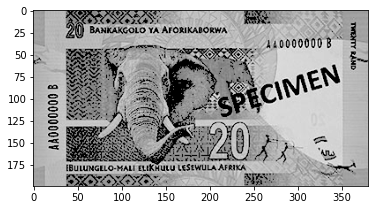

In [6]:
#Thresholding of the array of images
binary = []
for gray in grays:
  blurred = cv2.GaussianBlur(gray, (7, 7), 0)
  ret, thresh1 = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
  ret, thresh2 = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
  ret, thresh3 = cv2.threshold(gray, 120, 255, cv2.THRESH_TRUNC)
  ret, thresh4 = cv2.threshold(gray, 120, 255, cv2.THRESH_TOZERO)
  ret, thresh5 = cv2.threshold(gray, 120, 255, cv2.THRESH_TOZERO_INV)
  ret, thresh6 = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  adaptiveThresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
 
  binary.append(thresh4)
plt.imshow(binary[0], cmap = 'gray')

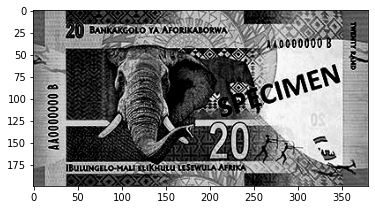

In [7]:
#Histogram normalisation of the therholded array of images
equ = []

for bin in binary:
  equalised = cv2.equalizeHist(bin)
  equ.append(equalised)

plt.imshow(equ[0], cmap = 'gray')

100


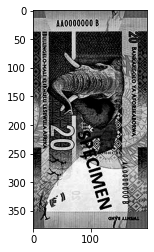

In [8]:
#Data augmentation is performed on the equalised images
#We take the first half (0-25) of the images and rotate them 90 degrees clockwise
#We take the second half (26-49) of the images and rotate them 90 degrees counterclockwise
#We do this to increase the size of our dataset
preprocessed = []
for i in range (len(equ)):
  if(i<=25):
    preprocessed.append(equ[i])
    preprocessed.append(cv2.rotate(equ[i],cv2.cv2.ROTATE_90_CLOCKWISE))
  if(i<=49 and i>25):
    preprocessed.append(equ[i])
    preprocessed.append(cv2.rotate(equ[i],cv2.cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.imshow(preprocessed[1], cmap = 'gray')
print(len(preprocessed))

END OF PREPROCESSING

ENHANCEMENT

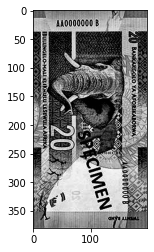

In [9]:
#Enhancement code
hist=[]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for pp in preprocessed:
  hist.append(clahe.apply(pp))

plt.imshow(hist[1], cmap = 'gray')

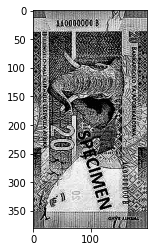

In [11]:
#Sharpening
sharp=[]
for h in hist:
  sharp.append(cv2.filter2D(src=h,ddepth=0,kernel=np.array([[0, -1, 0],[-1, 5,-1],[0, -1, 0]])))

plt.imshow(sharp[1],cmap='gray')

In [15]:
#Segmentation
class Point(object):
 def __init__(self,x,y):
  self.x = x
  self.y = y

 def getX(self):
  return self.x
 def getY(self):
  return self.y

def getGrayDiff(img,currentPoint,tmpPoint):
 return abs(int(img[currentPoint.x,currentPoint.y]) - int(img[tmpPoint.x,tmpPoint.y]))

def selectConnects(p):
 if p != 0:
  connects = [Point(-1, -1), Point(0, -1), Point(1, -1), Point(1, 0), Point(1, 1), \
     Point(0, 1), Point(-1, 1), Point(-1, 0)]
 else:
  connects = [ Point(0, -1), Point(1, 0),Point(0, 1), Point(-1, 0)]
 return connects

def regionGrow(img,seeds,thresh,p = 1):
 height, weight = img.shape
 seedMark = np.zeros(img.shape)
 seedList = []
 for seed in seeds:
  seedList.append(seed)
 label = 1
 connects = selectConnects(p)
 while(len(seedList)>0):
  currentPoint = seedList.pop(0)

  seedMark[currentPoint.x,currentPoint.y] = label
  for i in range(8):
   tmpX = currentPoint.x + connects[i].x
   tmpY = currentPoint.y + connects[i].y
   if tmpX < 0 or tmpY < 0 or tmpX >= height or tmpY >= weight:
    continue
   grayDiff = getGrayDiff(img,currentPoint,Point(tmpX,tmpY))
   if grayDiff < thresh and seedMark[tmpX,tmpY] == 0:
    seedMark[tmpX,tmpY] = label
    seedList.append(Point(tmpX,tmpY))
 return seedMark

 segmented = []
 for s in sharp:
   seeds = [Point(10,10),Point(82,150),Point(20,300)]
   segmented.append(regionGrow(s,seeds,10))
  
 plt.imshow(segmented[1],cmap='gray')

https://developpaper.com/simple-implementation-of-region-growing-in-python/ - Source used for segmentation code

FEATURE EXTRACTION

In [16]:
import math
# Hu moment features extracted from segmented images
Hu_moment_features = []
for i in segmented:
  im = i
  # Calculate Moments
  moments = cv2.moments(im)
  # Calculate Hu Moments
  huMoments = cv2.HuMoments(moments)
  # Log scale hu moments
  for i in range(0,7):
    huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))
  # Append features vector to array of feature vectors
  Hu_moment_features.append(huMoments)

print(Hu_moment_features)


NameError: ignored